# Trabajo Computacional 2

En este trabajo se presentarán los códigos utilizados para evaluar la validez de la regla de letalidad-centralidad en cuatro redes de interacción de proteínas de levadura. Luego se analizarán distintas causas subyacentes a esta correlación, analizando distintas propiedades topológicas de la red y su relación con la esencialidad en términos biológicos.

In [1]:
def ldata(archive): #abrir archivos txt
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data
def ldata2(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append([col[0],col[1]])
    return data
def ldata3(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col[1])
    return data

In [3]:
#Importamos distintos paquetes y nombramos las redes y la lista de proteínas esenciales
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy
from scipy import optimize
red_proteinas=ldata("tc02Data/yeast_AP-MS.txt") #Red AP-MS referida siempre como "RED PROTEÍNAS"
red_binarias=ldata("tc02Data/yeast_Y2H.txt") #Red Y2H (yeast to hybrid) referida como "RED BINARIAS"
red_literatura=ldata("tc02Data/yeast_LIT.txt") #Red yeast_LIT, reportada por la literatura, siempre como "RED LITERATURA"
red_litreguly=ldata2("tc02Data/yeast_LIT_Reguly.txt") #Red yeast_LIT_Reguly reportada como "RED LITREGULY"
Esencialidad=ldata3("tc02Data/Essential_ORFs_paperHe.txt") #Lista de proteínas esenciales

In [4]:
#Definimos los grafos de las cuatro redes como no dirigidos.
G = nx.Graph()
G.add_edges_from(red_proteinas) 
G1 = nx.Graph()
G1.add_edges_from(red_binarias)
G2 = nx.Graph()
G2.add_edges_from(red_literatura)
G3 = nx.Graph()
G3.add_edges_from(red_litreguly)

**Características de las redes analizadas**

In [5]:
#Definimos una función que da como resultado el grado medio de cada red, al calcular el grado de cada nodo,sumarlos y dividirlo por el total de nodos.
def K(H):
    k=sum(H.degree(k) for k in H)/H.number_of_nodes()
    salida=[k]
    return salida

**Tabla 1**: propiedades de cada red. Número de nodos, número de enlaces, grado medio y coeficiente de *clustering* local

In [6]:
data = pd.DataFrame({"Red":["Proteinas","Binarias","Literatura", "Literatura Reg."],
                     "Número de Nodos":[G.number_of_nodes(),G1.number_of_nodes(),G2.number_of_nodes(), G3.number_of_nodes()],
                     "Número de Enlaces":[G.number_of_edges(),G1.number_of_edges(),G2.number_of_edges(),G3.number_of_edges()],
                 "Grado medio ":[K(G),K(G1),K(G2),K(G3)],
                 "Clustering promedio":[nx.average_clustering(G),nx.average_clustering(G1),nx.average_clustering(G2),nx.average_clustering(G3)] })
cols= ['Red', 'Número de Nodos', 'Número de Enlaces', 'Grado medio ','Clustering promedio']

data[cols]


,Red,Número de Nodos,Número de Enlaces,Grado medio,Clustering promedio
0,Proteinas,1622,9070,[11.183723797780518],0.554636
1,Binarias,2018,2930,[2.9038652130822595],0.046194
2,Literatura,1536,2925,[3.80859375],0.292492
3,Literatura Reg.,3309,11859,[7.167724388032639],0.260976


Notar que la red binarias tiene *clustering* un orden de magnitud más bajo que el resto, que puede estar asociado a la forma de reportar las interacciones (la técnica experimental de sistema de doble híbrido)

Definimos la función de overlap entre dos redes: comparamos los enlaces en común, normalizado por el número de enlaces de cada red.

In [8]:
def overlap(J,K):
    a=0 #Usamos un contador
    for j in nx.edges(J):
        for i in nx.edges(K):
            if i==j or i[0]==j[1] and i[1]==j[0]: #Tener en cuenta que los enlaces pueden estar reportados de dos formas: A-B o B-A (al considerarlas no dirigidas son equivalentes)
                a+=1 
                
    return a/nx.number_of_edges(J), a/nx.number_of_edges(K) #El primer valor que devuelve es normalizado por la primera red, el segundo por la segunda

In [12]:
Over1=overlap(G,G1) #Overlap entre red proteínas y red binarias
Over2=overlap(G,G2) #Overlap entre red proteínas y red literatura
Over3=overlap(G,G3) #Overlap entre red proteínas y red litreguly
Over4=overlap(G1,G2) #Overlap entre red binarias y red literatura
Over5=overlap(G1,G3) #Overlap entre red binarias y red litreguly
Over6=overlap(G2,G3) #Overlap entre red literatura y red litreguly



Construimos la **Tabla 2**: *overlap* entre redes

In [13]:
data = pd.DataFrame({".":["Proteinas",Over1[0],Over2[0], Over3[0]],
                     "..":[Over1[1],"Binarias",Over4[0],Over5[0]],
                     "...":[Over2[1],Over4[1],"Literatura",Over6[0]],
                 "....":[Over3[1],Over5[1],Over6[1],"Literatura Reg."]})
cols= ['.', '..', '...', '....']

data[cols]
#La primera columna está normalizado por la red proteína, la segunda por binarias, tercera por literatura y cuarta por litreguly.

,.,..,...,....
0,Proteinas,0.0887372,0.443761,0.212497
1,0.0286659,Binarias,0.0888889,0.0403913
2,0.143109,0.0887372,Literatura,0.241167
3,0.277839,0.163481,0.977778,Literatura Reg.


Notar que la Tabla no es simétrica: esto se debe por la normalización elegida.

Vemos cuan distintas son las distribuciones de grado para todo el grafo y para nodos esenciales

In [27]:
def Grados(Grafo): #Calcula el grado de cada nodo en el grafo
    KNodos=[]
    for i in Grafo:
        KNodos.append(Grafo.degree(i))
    return KNodos 

In [28]:
def HistogramaGrados(Grafo):  #Devuelve un histograma con la distribución de grado 
    F=Grados(Grafo)
    plt.hist(F,bins=max(F))
    plt.title("Distribución de grado")
    plt.xlabel("Grado")
    return plt.show()

Creamos una función que asigne nodos esenciales y su grado para cada grafo

In [29]:
def NodosEsencialesGrado(J,K):
    NE=[]
    k=[]
    for i in nx.nodes(J): #Comparamos los nodos del grafo con los de la lista de esencialidad
        for j in K:
            if i==j:
                NE.append(i) #Completamos una lista con los nodos esenciales presentes en ese grafo
                k.append(J.degree(i)) #Completamos una lista con los grados de esos nodos
    return k, NE    

In [30]:
def Histograma(J,K):  #Devuelve un histograma con la distribución de grado para nodos esenciales
    F=NodosEsencialesGrado(J,K)
    plt.hist(F[0],bins=max(F[0]))
    plt.title("Distribución de grado en los nodos esenciales")
    plt.xlabel("Grados de los nodos esenciales")
    return plt.show()

Red Proteínas


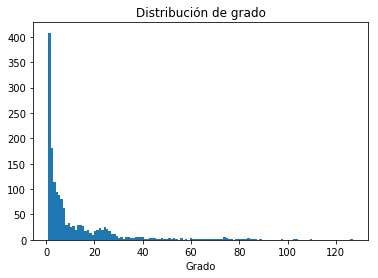

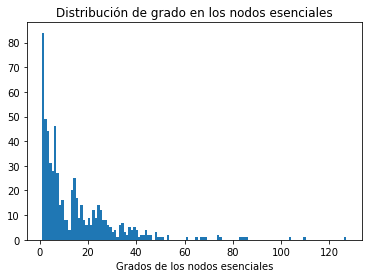

None None


In [32]:
print("Red Proteínas")
print(HistogramaGrados(G),Histograma(G,Esencialidad))

Red Binarias


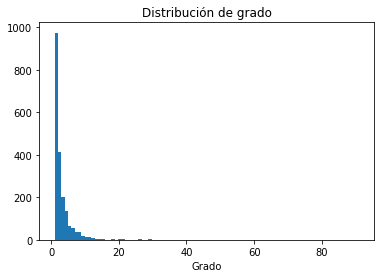

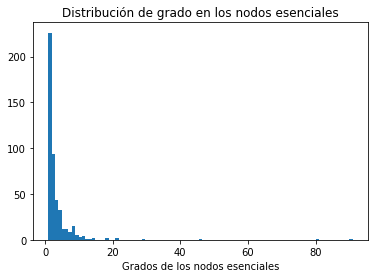

None None


In [33]:
print("Red Binarias")
print(HistogramaGrados(G1),Histograma(G1,Esencialidad))

Red Literatura


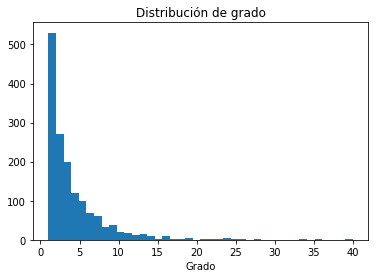

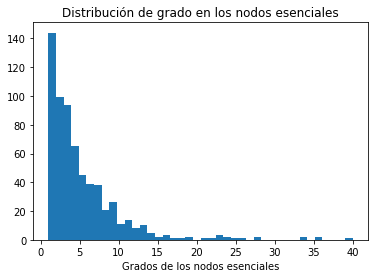

None None


In [34]:
print("Red Literatura")
print(HistogramaGrados(G2),Histograma(G2,Esencialidad))

Red LitReguly


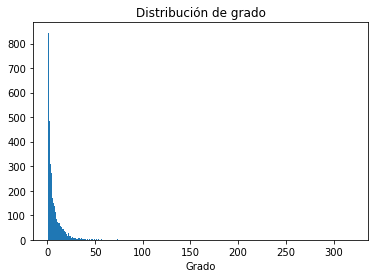

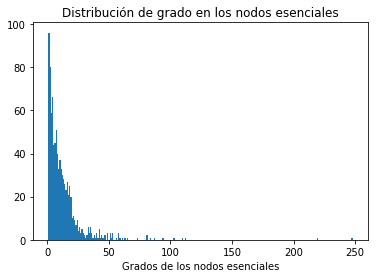

None None


In [35]:
print("Red LitReguly")
print(HistogramaGrados(G3),Histograma(G3,Esencialidad))

**Relación entre el grado y la esencialidad en las redes analizadas**

Vemos cual es la relación entre el grado y la esencialidad en cada red. Creamos una función que tome la componente gigante de cada red, luego genere una lista con el grado de los nodos esenciales presentes en esa componente,y el grado de todos los nodos de la CG. Luego hace un barrido en distintos grados de corte para la definición de *hubs* y cuanta cuantos nodos forman parte del mismo, por un lado sólo esenciales, por otro todos. Luego se calcula la fracción de nodos esenciales sobre el total del *hub* y la fracción de nodos *hubs* sobre el número de nodos de la componente gigante.

In [39]:
def Zotenko(Grafo,Lista):
    Gcc = sorted(nx.connected_component_subgraphs(Grafo), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = Gcc[0] #Elegimos la componente gigante de la red
    ###Acá seteamos los esenciales y le damos su grado
    
    k=[] #Lista de grados de los nodos esenciales en la componente gigante
    for i in nx.nodes(G0):
        for j in Lista:
            if i==j:
                k.append(G0.degree(i))
    
    ###Seteamos todos los nodos y su grado
    
    K=[] #Lista de grados de todos los nodos de la componente gigante
    for i in nx.nodes(G0):
        K.append(G0.degree(i))
    
    ###Número de hubs (normalizado) y k0
    #Eje x
    A=[] #Lista que contiene el número de nodos hubs sobre el total de nodos en la CG para cada grado cutoff
    B=[] #Lista de fracción de nodos esenciales hubs sobre el total de hubs para cada cutoff
    for k0 in set(K): #ko es el grado mínimo a partir del cual se considera hub, se toma la lista de grados y se ve que valores hay presentes, se eligen como cutoff
        a=0 #Un contador para contar hubs
        for i in K:
            if i>=k0: #Condición para que sean hubs: grado mayor o igual al grado de definición o cutoff
                a+=1
        A.append(a/nx.number_of_nodes(G0))

        ###El eje y  
        
        b=0
        for l in k:
            if l>=k0: # La condición es la misma pero corriendo sobre la lista de grados de nodos esenciales
                b+=1 #Contando
        B.append(b/a) #Normalizado por el número de nodos hubs
    
    return A,B #Nos devuelve lo que va en cada eje

In [40]:
Ñ=Zotenko(G,Esencialidad) #Fracción de hubs esenciales para cada cutoff para RED PROTEÍNAS
Ñ1=Zotenko(G1,Esencialidad)#Fracción de hubs esenciales para cada cutoff para RED BINARIAS
Ñ2=Zotenko(G2,Esencialidad) #Fracción de hubs esenciales para cada cutoff para RED LITERATURA
Ñ3=Zotenko(G3,Esencialidad) #Fracción de hubs esenciales para cada cutoff para RED LITREGULY

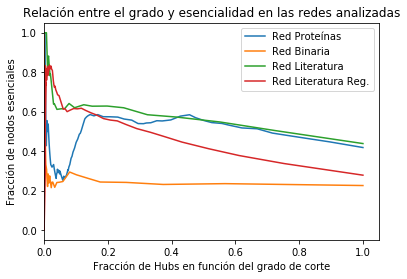

In [41]:
plt.plot(Ñ[0],Ñ[1],label="Red Proteínas")
plt.plot(Ñ1[0],Ñ1[1],label="Red Binaria")
plt.plot(Ñ2[0],Ñ2[1],label="Red Literatura")
plt.plot(Ñ3[0],Ñ3[1],label="Red Literatura Reg.")
plt.xlim(xmin=0)
plt.legend()
plt.title("Relación entre el grado y esencialidad en las redes analizadas")
plt.ylabel("Fracción de nodos esenciales")
plt.xlabel("Fracción de Hubs en función del grado de corte")
plt.show()

**Análisis de vulnerabilidad de las redes**

Vamos a desarmar la componente gigante de cada red al sacar nodos de acuerdo a la centralidad que tengan, en orden decreciente. Se trabajaron con cinco centralidades. 

In [45]:
def Nnodos (H):    #Función que da el número de nodos de la componente gigante de un grafo
    Gcc = sorted(nx.connected_component_subgraphs(H), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = Gcc[0] #componente gigante 
    return G0.number_of_nodes()
    
def Sacando_nodos(Grafo,GN,NumeroDeNodo): #Función que saca nodos a partir de una lista ordenada
    G=Grafo
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
    NnodosComponenteGigante=[]
    NodosQueSaco=[]
    N=0
    for g,n in GN:
        if N<NumeroDeNodo-1:#número de nodos menos 1 

            N+=1
            Gcc[0].remove_node(n)
            NnodosComponenteGigante.append(Nnodos(Gcc[0])) #me devuelve el número de nodos de la componente gigante 
            NodosQueSaco.append(N) #me devuelve el número de nodos que saque hasta el momento (=número de pasos)
                                    
    return NnodosComponenteGigante, NodosQueSaco

def Shuffle_en_nodo(lista,orden,GradoMaximo):  #Función que me devuelve lista de grado-nodo pero que shufflea dentro de los nodos de mismo grado 
    GNordenado_shuflle=[]
    RANGO=[i for i in range(1,GradoMaximo+1)]#lo defino hasta el grado máximo, sino no tengo más cosas que sacar
    if orden=="AS": #Si es ascendente o no
        for i in RANGO:
            GRADO=[]
            NODO=[]

            for j in lista:
                if j[0]==i:
                    GRADO.append(j[0])
                    NODO.append(j[1])

            random.shuffle(NODO)
            a=0
            for h in GRADO:
                GNordenado_shuflle.append([h,NODO[a]])
                a+=1
    else:
        RANGO=sorted(RANGO, reverse=True)
        for i in RANGO:
            GRADO=[]
            NODO=[]

            for j in lista:
                if j[0]==i:
                    GRADO.append(j[0])
                    NODO.append(j[1])

            random.shuffle(NODO)
            a=0
            for h in GRADO:
                GNordenado_shuflle.append([h,NODO[a]])
                a+=1
        
    return GNordenado_shuflle

In [46]:
def DemoliendoRedes(Grafo,NumeroDeNodos,Centralidad,iteraciones): #Función que saca nodos por una lista ordenada de acuerdo a una centralidad
    G=copy.deepcopy(Grafo) #Realizo una copia del grafo para poder sacarle los nodos
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True) #Elijo componente gigante
    NnodosComponenteGigante=[]
    NQS=list(np.arange(1,NumeroDeNodos)) #Hasta el número de nodos de la CG
    NodosQueSaco=[]
    for i in NQS:
        NodosQueSaco.append(i/NumeroDeNodos) #Número de nodos que saqué de la red sobre el número total de nodos
    
    N=0 #Defino un contador 
    if Centralidad=="Grado": #Defino con qué centralidad ordeno los nodos
        C=nx.degree_centrality(Gcc[0]) 
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True) #Ordeno de mayor a menor grado
        Nodos=[nodo for g,nodo in C_N] #Nodos ordenados
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1 #Cuento 
                Gcc[0].remove_node(n) #Saco nodos de forma ordenada 
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos) #Calculo en número de nodos que quedan en la CG sobre el total inicial
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Autovector":
        C=nx.eigenvector_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Subgrafo":
        C=nx.communicability_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="CaminoMasCorto":
        C=nx.betweenness_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Flujo":
        C=nx.current_flow_closeness_centrality(Gcc[0])
        C_N=sorted([[C[nodo],nodo] for nodo in C], reverse=True)
        Nodos=[nodo for g,nodo in C_N]
        for n in Nodos[:NumeroDeNodos-1]:
            if N<NumeroDeNodos-1:
                N+=1
                Gcc[0].remove_node(n)
                NnodosComponenteGigante.append(Nnodos(Gcc[0])/NumeroDeNodos)
#                NodosQueSaco.append(N/NumeroDeNodos)
    if Centralidad=="Random": #Saco nodos de forma random, tengo que iterar 
        NodosCG=[]
        for j in range(iteraciones):
            NN=0
            G_j=copy.deepcopy(Gcc[0]) #Trabajo con una copia para cada iteración
            Nodos=list(G_j.nodes())
            random.shuffle(Nodos) #Reordeno de forma aleatoria los nodos
            NnodosCGrandom=[]
            for n in Nodos[:NumeroDeNodos-1]:
                if NN<NumeroDeNodos-1:
                    NN+=1
                    G_j.remove_node(n) #Saco los nodos en cada iteración
                    NnodosCGrandom.append(Nnodos(G_j)/NumeroDeNodos) 
#                    NodosQueSaco.append(NN/NumeroDeNodos) 
            NodosCG.append(NnodosCGrandom) 
        
        for i in range(NumeroDeNodos-1):
            lista=[]
            for k in range(iteraciones):
                lista.append(NodosCG[k][i])
            NnodosComponenteGigante.append(sum(lista)/iteraciones) #Lista promediada 
        
        
    return NnodosComponenteGigante, NodosQueSaco       

In [47]:
#Defino listas con los parámetros a completar en la función anterior
Centralidades=["Grado","Autovector","CaminoMasCorto","Flujo", "Random"] #Defino una lista de centralidades
Grafos=[G,G1,G2,G3] #Lista de grafos
TamañoComponenteGigante=[Nnodos(G),Nnodos(G1),Nnodos(G2),Nnodos(G3)] #Lista de tamaños de cada grafo (componente gigante)

In [18]:
#Creo txt con la información
def creartxt(lista1,lista2,NombreArchivo):         ##Lo único que hay que decirle es las dos listas a guardar. Se podrían guardar más, pero hace falta agregar un par de cosas
    with open(NombreArchivo,'w') as f:             ##Nombre de archivo hay que ponerlo entre comillas y punto txt. Es el nombre que queremos que tenga el archivo
        a=0
        for item in lista1:
            f.write("{}\t{}\n".format(item,lista2[a]))
            a+=1

In [ ]:
TodoG=[] #Calculo para la RED PROTEINAS
for i in Centralidades: #Me corro en todas las centralidades definidas
    F=DemoliendoRedes(G,Nnodos(G),i,1000) #1000 iteraciones para la random
    TodoG.append(F)
    creartxt(F[0],F[1],"G_{}.txt".format(i)) #Tengo un text para cada centralidad


In [15]:
TodoG1=[] #Calculo para la RED BINARIAS
for i in Centralidades:
    F=DemoliendoRedes(G1,Nnodos(G1),i,1000)
    TodoG1.append(F)
    creartxt(F[0],F[1],"G1_{}.txt".format(i))

TodoG2=[] #Calculo para RED LITERATURA
for i in Centralidades:
    F=DemoliendoRedes(G2,Nnodos(G2),i,1000)
    TodoG2.append(F)
    creartxt(F[0],F[1],"G2_{}.txt".format(i))

TodoG3=[] #Calculo para RED LITREGULY
for i in Centralidades:
    F=DemoliendoRedes(G3,Nnodos(G3),i,1000)
    TodoG3.append(F)
    creartxt(F[0],F[1],"G3_{}.txt".format(i))

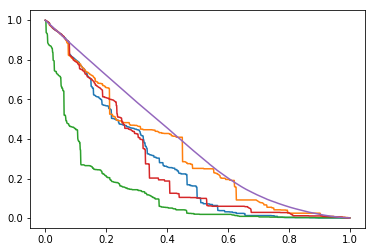

In [34]:
plt.plot(Todo[0][0][1],Todo[0][0][0])
plt.plot(Todo[0][1][1],Todo[0][1][0])
plt.plot(Todo[0][2][1],Todo[0][2][0])
plt.plot(Todo[0][3][1],Todo[0][3][0])
plt.plot(Todo[0][3][1],Todo[0][4][0])
plt.show()

In [20]:
#LECTURA Para trabajar con los archivos txt de la carpeta DemoliendoRedes          
def leetxt(NombreArchivo):    ##Le ponés entre comillas y .txt el nombre del archivo y lo lee
    lectura1=[]               ##la función devuelve dos listas. la primera es la lista1 de arriba, la segunda la lista2
    lectura2=[]               ##Para aplicarla es poner f=leetxt("NombreArchivo.txt")
    with open(NombreArchivo, 'r') as f: ## f[0] va a ser lista1
        contenido= f.readlines()        ## f[1] va a ser lista2
        for x in contenido:             ## Al igual que la de arriba se puede extender fácil a más de dos listas
            row = x.split()
            lectura1.append(float(row[0]))
            lectura2.append(float(row[1]))
    return lectura1, lectura2

In [21]:
TodoG=[]
for j in Centralidades:
    TodoG.append(leetxt("DemoliendoRedes/G_{}.txt".format(j)))

TodoG1=[]
for j in Centralidades:
    TodoG1.append(leetxt("DemoliendoRedes/G1_{}.txt".format(j)))
TodoG2=[]
for j in Centralidades:
    TodoG2.append(leetxt("DemoliendoRedes/G2_{}.txt".format(j)))

TodoG3=[]
for j in Centralidades:
    TodoG3.append(leetxt("DemoliendoRedes/G3_{}.txt".format(j)))

SacandoEsenciales_NoEsRandom_G=leetxt("SacandoEsenciales_NoEsRandom_G0.txt")
SacandoEsenciales_NoEsRandom_G1=leetxt("SacandoEsenciales_NoEsRandom_G3.txt")
SacandoEsenciales_NoEsRandom_G2=leetxt("SacandoEsenciales_NoEsRandom_G2.txt")
SacandoEsenciales_NoEsRandom_G3=leetxt("SacandoEsenciales_NoEsRandom_G1.txt")

Grafico para cada red

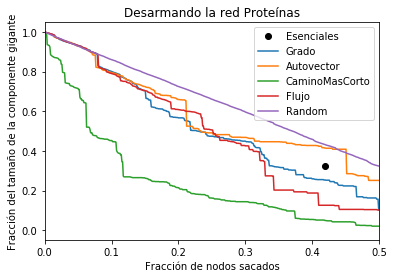

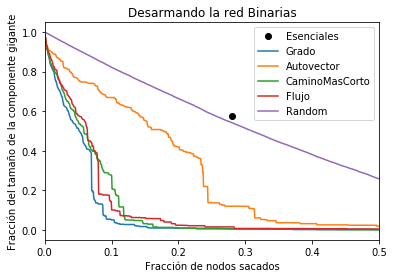

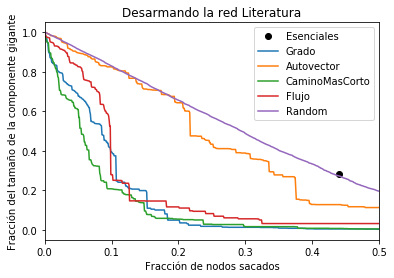

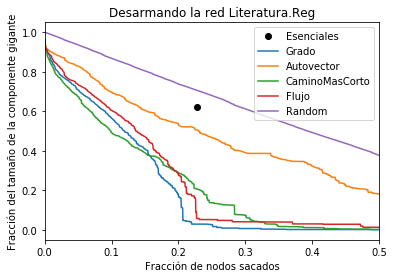

In [22]:
xmax=.5
plt.xlim(xmax=xmax)
plt.plot(SacandoEsenciales_NoEsRandom_G[0][1],SacandoEsenciales_NoEsRandom_G[0][0], "ko",label="Esenciales")
plt.plot(TodoG[0][1],TodoG[0][0],label="Grado")
plt.plot(TodoG[1][1],TodoG[1][0], label="Autovector")
plt.plot(TodoG[2][1],TodoG[2][0], label="CaminoMasCorto")
plt.plot(TodoG[3][1],TodoG[3][0], label="Flujo")
plt.plot(TodoG[4][1],TodoG[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Proteínas")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

plt.xlim(xmax=xmax)
plt.plot(SacandoEsenciales_NoEsRandom_G1[0][1],SacandoEsenciales_NoEsRandom_G1[0][0], "ko",label="Esenciales")
plt.plot(TodoG1[0][1],TodoG1[0][0],label="Grado")
plt.plot(TodoG1[1][1],TodoG1[1][0], label="Autovector")
plt.plot(TodoG1[2][1],TodoG1[2][0], label="CaminoMasCorto")
plt.plot(TodoG1[3][1],TodoG1[3][0], label="Flujo")
plt.plot(TodoG1[4][1],TodoG1[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Binarias")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

plt.xlim(xmax=xmax)
plt.plot(SacandoEsenciales_NoEsRandom_G2[0][1],SacandoEsenciales_NoEsRandom_G2[0][0], "ko",label="Esenciales")
plt.plot(TodoG2[0][1],TodoG2[0][0],label="Grado")
plt.plot(TodoG2[1][1],TodoG2[1][0], label="Autovector")
plt.plot(TodoG2[2][1],TodoG2[2][0], label="CaminoMasCorto")
plt.plot(TodoG2[3][1],TodoG2[3][0], label="Flujo")
plt.plot(TodoG2[4][1],TodoG2[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Literatura")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

plt.xlim(xmax=xmax)
plt.plot(SacandoEsenciales_NoEsRandom_G3[0][1],SacandoEsenciales_NoEsRandom_G3[0][0], "ko",label="Esenciales")
plt.plot(TodoG3[0][1],TodoG3[0][0],label="Grado")
plt.plot(TodoG3[1][1],TodoG3[1][0], label="Autovector")
plt.plot(TodoG3[2][1],TodoG3[2][0], label="CaminoMasCorto")
plt.plot(TodoG3[3][1],TodoG3[3][0], label="Flujo")
plt.plot(TodoG3[4][1],TodoG3[4][0], label="Random")
plt.legend()
plt.title("Desarmando la red Literatura.Reg")
plt.xlabel("Fracción de nodos sacados")
plt.ylabel("Fracción del tamaño de la componente gigante")
plt.show()

In [68]:
RandomG=DemoliendoRedes(G,Nnodos(G),"Random",50)
creartxt(RandomG[0],RandomG[1],"G_Random.txt")
RandomG1=DemoliendoRedes(G1,Nnodos(G1),"Random",50)
creartxt(RandomG1[0],RandomG1[1],"G1_Random.txt")

RandomG2=DemoliendoRedes(G2,Nnodos(G2),"Random",50)
creartxt(RandomG2[0],RandomG2[1],"G2_Random.txt")



Saco nodos esenciales de una vez, y luego veo de sacar nodos con distribución de grado similar que no sean esenciales

In [57]:
RandomG3=DemoliendoRedes(G3,Nnodos(G3),"Random",25)
creartxt(RandomG3[0],RandomG3[1],"G3_Random.txt")

a=0
for i in Grafos:
    P=SacandoEsenciales_NoEsRandom(i,Esencialidad,100)
    K=list(np.array(P).reshape(2,2))
    creartxt(K[0],K[1],"SacandoEsenciales_NoEsRandom_G{}.txt".format(a))
    a+=1

In [23]:
def SacandoEsenciales_NoEsRandom(Grafo,Lista,iteraciones):
    Gcc = sorted(nx.connected_component_subgraphs(Grafo), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    G0 = copy.deepcopy(Gcc[0]) #Copia de la componente gigante
    ###Acá seteamos los esenciales y le damos su grado
    NE=[]
    kE=[]
    for i in nx.nodes(G0): #lista de nodos en la CG
        for j in Lista: #Saco nodos que sean esenciales
            if i==j: # Es esencial?
                F=G0.degree(i) #Calculo el grado del nodo en cuestión
                NE.append(i) #Lista de los nodos esenciales que saco
                kE.append(F) #Genero una lista de grados de los nodos que voy sacando-esenciales-
    G0.remove_nodes_from(NE) #Saco esenciales
    
    ##Ahora quiero sacar nodos no esenciales con distribución de grado similar
    
    kNoE=[] 
    kNoE_NoEse=[]
    for i in nx.nodes(Gcc[0]):
        for j in NE: #Lista de nodos esenciales en ese grafo
            if i!=j: #Si NO son esenciales
                F=Gcc[0].degree(i) #calculo su grado
                kNoE.append(F) #Completo una lista con su grado
                kNoE_NoEse.append([F,i]) #Su grado y nombre para no esenciales
     
    kNoE_NoEse=sorted(kNoE_NoEse) #La ordeno
    
    ##
    
    NoFinal=[]
    for j in range(iteraciones): #Vamos a iterar porque habrá nodos con el mismo grado, cambiará cual saco en cada iteración   
        G1=copy.deepcopy(Gcc[0]) 
        B=Shuffle_en_nodo(kNoE_NoEse,"UP",max(kNoE)) #Reordeno la lista 
        NodosAsacar=[]
        for i in kE: #Para cada grado de nodos esenciales 
            index=int(0) #Me muevo en un índice
            a=0 #Un contador
            while(a==0): #control de que se cumpla la condicion
                if B[index][0]<=i:
                    NodosAsacar.append(B[index][1]) #Saco el nodo con el grado del esencial
                    del(B[index])
                    a=1 #Si ya hay un nodo con ese grado redefino a y deja de hacerlo
                else: #Si no encuentro el mismo grado me muevo al siguiente- lista ordenada reverse-
                    index=int(index+1)
        G1.remove_nodes_from(NodosAsacar)
        NoFinal.append(Nnodos(G1))
    Final=sum(NoFinal)/iteraciones #Promedio
    Desviacion=np.std(NoFinal)/Final #Veo la desviación estándar de las iteraciones
    
    Nnodos_=Nnodos(Gcc[0])
    
    return Nnodos(G0)/Nnodos_, len(NE)/Nnodos_, Final/Nnodos_, Desviacion #Las primeras nos dan el x e y del pto de los gráficos, luego tengo los valores para lo random
    

**Esencialidad: módulos biológicos vs interacciones esenciales**

In [24]:
#Vamos a calcular el número de pares de nodos no adyacentes que compartan tres o más vecinos (para red binaria uno o más).
#Trabajamos con la matriz de adyancencia
def NumeroPares(G):
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    Grafo = Gcc[0] #Tomo la componente gigante
    
    J=nx.convert_matrix.to_numpy_matrix(Grafo) #Creo la matriz de adyacencia
    A=J*J #Matriz de adyacencia al cuadrado
    N=nx.number_of_nodes(Grafo) #Defino el número de nodos, va a dar el tamaño de la fila/columna de la matriz
    a=0
    if Grafo!=G1: #Para los que no sean red binaria calculo con tres o más vecinos
        for i in range(N): #me muevo en una fila 
            for j in range(i+1,N): #veo en la diagonal superior, no cuento los de la diagonal
                if J[i,j]==0: #veo que no sean adyacentes
                    if A[i,j]>=3: #a partir de la matriz al cuadrado veo cuantos vecinos en común: el elemento ij es cuántos caminos de dos pasos los conectan: si hay mas de tres es que tienen más de tres vecinos en común
                        a+=1 #los cuento
    else: #Para red binarias veo si tienen uno o más vecinos en común
        for i in range(N):
            for j in range(i+1,N):
                if J[i,j]==0:
                    if A[i,j]>=1:
                        a+=1
    return a #Cuento los pares


def NumeroParesIguales(G,Lista): #Cuento cuántos son del mismo tipo
    Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True) #ordeno los subgrafos de mayor a menor segun su tama;o
    Grafo = Gcc[0]
    
    J=nx.convert_matrix.to_numpy_matrix(Grafo)
    A=J*J
    N=nx.number_of_nodes(Grafo)
    Nodos=list(Grafo.nodes())
    NE=[]
    for i in Grafo:
        for j in Lista:
            if i==j:
                NE.append(i) #Lista de nodos esenciales en cada grafo
    
    a=0    
    if Grafo!=G1: #Que no sean red binaria: tres o más vecinos
        for i in range(N):
            for j in range(i+1,N):
                if J[i,j]==0:
                    n=Nodos[i] in NE #veo si son esenciales o no
                    m=Nodos[j] in NE
                    if n==m: #si ambos son esenciales o si ambos no lo son 
                        if A[i,j]>=3:
                            a+=1 #Cuento pares
    else: #Para red binarias: uno o mas vecinos en común
        for i in range(N):
            for j in range(i+1,N):
                if J[i,j]==0:
                    n=Nodos[i] in NE
                    m=Nodos[j] in NE
                    if n==m:
                        if A[i,j]>=1:
                            a+=1
    return a

In [25]:
NumeroPares_G=NumeroPares(G) #Número de pares para RED PROTEINAS
NumeroPares_G1=NumeroPares(G1) #Número de pares para RED BINARIAS
NumeroPares_G2=NumeroPares(G2)#Número de pares para RED LITERATURA
NumeroPares_G3=NumeroPares(G3)#Número de pares para RED LITREGULY

NumeroParesIguales_G=NumeroParesIguales(G,Esencialidad) #Número de pares del mismo tipo para la RED PROTEÍNAS
NumeroParesIguales_G1=NumeroParesIguales(G1,Esencialidad) #Número de pares del mismo tipo para la RED BINARIAS
NumeroParesIguales_G2=NumeroParesIguales(G2,Esencialidad) #Número de pares del mismo tipo para la RED LITERATURA
NumeroParesIguales_G3=NumeroParesIguales(G3,Esencialidad) #Número de pares del mismo tipo para la RED LITREGULY

print(NumeroPares_G,NumeroPares_G1,NumeroPares_G2,NumeroPares_G3)
print(NumeroParesIguales_G,NumeroParesIguales_G1,NumeroParesIguales_G2,NumeroParesIguales_G3)

11569 522 718 10777
5875 352 383 6187


Obtengo alfa y beta de ajustes

In [26]:
def Grado_Esencialidad(Grafo,Lista,cota):
    k_esencialidad=[]
    k=[]
    for i in Grafo.nodes():
        m=i in Lista #Veo si son esenciales
        n=Grafo.degree(i) #grado
        k_esencialidad.append([n,m]) # lista de grado, si son esenciales o no
        k.append(n)
    K=list(set(k)) #Tomo los valores que aparecen y no los repito
    A=[]
    B=[]
    for i in K: #Me muevo en la lista de grados existentes
        a=0 #Contador de nodos esenciales para un dado grado k
        b=0 #Contador de nodos para un dado k
        for j in k_esencialidad: #me muevo en la lista de grado y esencialidad si o no
            if j[0]==i: #si coinciden los grados contalo
                b+=1
                if j[1]==True: #si además son esenciales contalo
                    a+=1
        if b>=cota: #elijo un número que considere suficiente para tener estadística y asociarlo a una probabilidad confiable
            A.append(a/b) #es la probabilidad de que para un dado grado k sea esencial
            B.append(i) #grado
    return k_esencialidad, A,B

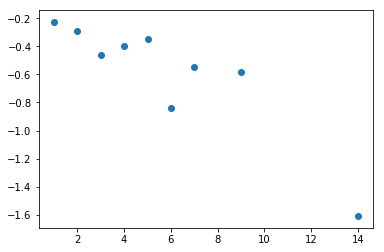

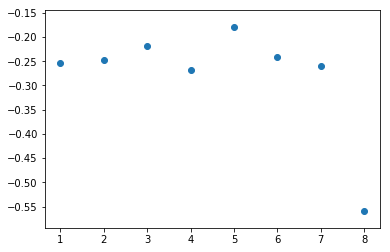

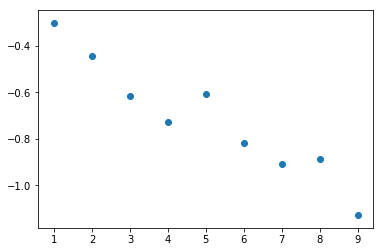

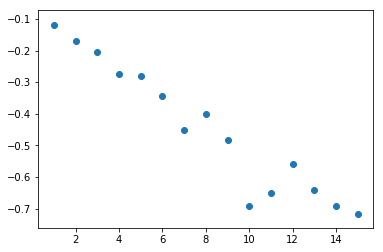

In [27]:
Grado_Esencialidad_G=Grado_Esencialidad(G,Esencialidad,30) #RED PROTEÍNAS
K=[]
b=15
for i in Grado_Esencialidad_G[1][:b]:
    K.append(np.log(1-i)) #Calculo el logaritmo de la prob de no ser esencial
plt.scatter(Grado_Esencialidad_G[2][:b],K)
plt.show()

Grado_Esencialidad_G1=Grado_Esencialidad(G1,Esencialidad,30) #RED BINARIAS
L=[]

for i in Grado_Esencialidad_G1[1][:b]:
    L.append(np.log(1-i))
plt.scatter(Grado_Esencialidad_G1[2][:b],L)
plt.show()

Grado_Esencialidad_G2=Grado_Esencialidad(G2,Esencialidad,30) #RED LITERATURA
M=[]

for i in Grado_Esencialidad_G2[1][:b]:
    M.append(np.log(1-i))
plt.scatter(Grado_Esencialidad_G2[2][:b],M)
plt.show()

Grado_Esencialidad_G3=Grado_Esencialidad(G3,Esencialidad,30) #RED LITREGULY
N=[]

for i in Grado_Esencialidad_G3[1][:b]:
    N.append(np.log(1-i))
plt.scatter(Grado_Esencialidad_G3[2][:b],N)
plt.show()


Se ve una tendencia lineal, vemos de ajustar para obtener parámetros

In [28]:
def fiteadora(p,x):
    return p[0]+p[1]*x #Ajusto por una lineañ

def error(p,x,y):
    return fiteadora(p,x)-y

In [29]:
P_ini=[-.3,-.3] #Optimizo parámetros ajuste

out= optimize.leastsq(error,P_ini,args=(np.array(Grado_Esencialidad_G[2][:b]),np.array(K)),full_output=1)
pfinal = out[0]
covar = out[1]
p0err=np.sqrt( covar[0][0] )
p1err= np.sqrt( covar[1][1] )
print(pfinal[0],p0err,pfinal[1],p1err)

out1= optimize.leastsq(error,P_ini,args=(np.array(Grado_Esencialidad_G1[2][:7]),np.array(L[:7])),full_output=1)
pfinal1 = out1[0]
covar1 = out1[1]
p0err1=np.sqrt( covar1[0][0] )
p1err1= np.sqrt( covar1[1][1] )
print(pfinal1[0],p0err1,pfinal1[1],p1err1)

out2= optimize.leastsq(error,P_ini,args=(np.array(Grado_Esencialidad_G2[2][:b]),np.array(M)),full_output=1)
pfinal2 = out2[0]
covar2 = out2[1]
p0err2=np.sqrt( covar2[0][0] )
p1err2= np.sqrt( covar2[1][1] )
print(pfinal2[0],p0err2,pfinal2[1],p1err2)

out3= optimize.leastsq(error,P_ini,args=(np.array(Grado_Esencialidad_G3[2][:b]),np.array(N)),full_output=1)
pfinal3 = out3[0]
covar3 = out3[1]
p0err3=np.sqrt( covar3[0][0] )
p1err3= np.sqrt( covar3[1][1] )
print(pfinal3[0],p0err3,pfinal3[1],p1err3)

-0.053567711504061144 0.6016470279146194 -0.09446733849334765 0.08838834727580316
-0.24417377560159806 0.8451543200182113 0.0013883120715256938 0.18898224744303188
-0.2736663981245902 0.7264831565305917 -0.0882831434579295 0.12909944427752362
-0.08833947786759395 0.5433581692952557 -0.04460931067524744 0.05976143084177423


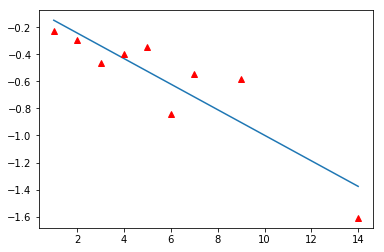

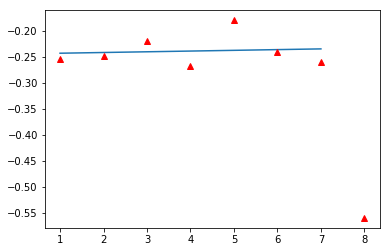

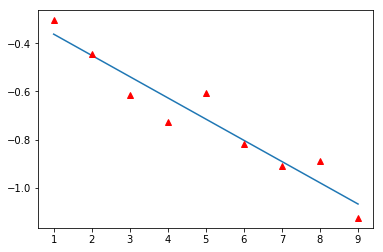

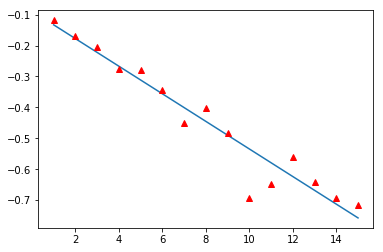

In [30]:
plt.plot(Grado_Esencialidad_G[2][:b],np.array(Grado_Esencialidad_G[2][:b])*pfinal[1]+pfinal[0])
plt.plot(Grado_Esencialidad_G[2][:b],K,"r^")
plt.show()

plt.plot(Grado_Esencialidad_G1[2][:7],np.array(Grado_Esencialidad_G1[2][:7])*pfinal1[1]+pfinal1[0])
plt.plot(Grado_Esencialidad_G1[2][:b],L,"r^")
plt.show()

plt.plot(Grado_Esencialidad_G2[2][:b],np.array(Grado_Esencialidad_G2[2][:b])*pfinal2[1]+pfinal2[0])
plt.plot(Grado_Esencialidad_G2[2][:b],M,"r^")
plt.show()

plt.plot(Grado_Esencialidad_G3[2][:b],np.array(Grado_Esencialidad_G3[2][:b])*pfinal3[1]+pfinal3[0])
plt.plot(Grado_Esencialidad_G3[2][:b],N,"r^")
plt.show()

In [32]:
##Calculemos alpha y beta
def beta_alfa(x):
    return 1-np.e**x[0], 1-np.e**x[1] #a partir del ajuste

beta_alfa_G=beta_alfa(pfinal)
beta_alfa_G1=beta_alfa(pfinal1)
beta_alfa_G2=beta_alfa(pfinal2)
beta_alfa_G3=beta_alfa(pfinal3)


In [33]:
print(beta_alfa_G,beta_alfa_G1,beta_alfa_G2,beta_alfa_G3) 

(0.05215824096021748, 0.09014254854406745) (0.2166485049429473, -0.001389276222859115) (0.23941423421941288, 0.08449837827303619) (0.08454995106376806, 0.04362894718591215)


Con los valores de alfa y beta podemos obtener cuántos pares del mismo tipo obtendríamos al azar

In [73]:
def Esencialidad_Random(Grafo,x):
    Esencialidad=[]
    
    for i in Grafo.nodes():
        p=np.random.random() #generamos números al azar entre 0 y 1 para cada nodo
        BA=beta_alfa(x)
        p_k=1-(1-BA[0])*(1-BA[1])**Grafo.degree(i) #calculamos para ese nodo la probabilidad de que sea esencial o no a partir de alfa y beta según su grado
        if p<=p_k: #evaluamos si es esencial o no comparando con el número random 
            Esencialidad.append(i) #genero una nueva lista de esencialidad
                
    return Esencialidad

In [123]:
NPIG=[]
NPIG1=[]
NPIG2=[]
NPIG3=[]
for i in range(100): #lo repito para promediar
    ERG=Esencialidad_Random(G,pfinal) #completo cada lista en una lista
    ERG1=Esencialidad_Random(G1,pfinal1)
    ERG2=Esencialidad_Random(G2,pfinal2)
    ERG3=Esencialidad_Random(G3,pfinal3)

    NPIG.append(NumeroParesIguales(G,ERG))
    NPIG1.append(NumeroParesIguales(G1,ERG1))
    NPIG2.append(NumeroParesIguales(G2,ERG2))
    NPIG3.append(NumeroParesIguales(G3,ERG3))
    
NPIpromG=sum(NPIG)/100 #las promedio
NPIstdG=np.std(NPIG)/NPIpromG

NPIpromG1=sum(NPIG1)/100
NPIstdG1=np.std(NPIG1)/NPIpromG1

NPIpromG2=sum(NPIG2)/100
NPIstdG2=np.std(NPIG2)/NPIpromG2

NPIpromG3=sum(NPIG3)/100
NPIstdG3=np.std(NPIG3)/NPIpromG3

KeyboardInterrupt: 

In [130]:
NPIpromG=sum(NPIG)/100
NPIstdG=np.std(NPIG)/NPIpromG

NPIpromG1=sum(NPIG1)/100
NPIstdG1=np.std(NPIG1)/NPIpromG1

NPIpromG2=sum(NPIG2)/100
NPIstdG2=np.std(NPIG2)/NPIpromG2

NPIpromG3=sum(NPIG3)/100
NPIstdG3=np.std(NPIG3)/NPIpromG3

Nuevos valores para los pares de mismo tipo a partir del ajuste

In [131]:
print(NPIpromG,NPIstdG)

5125.05 0.046840265596066466


In [132]:
print(NPIpromG1,NPIstdG2)

203.02 0.10309982998651648


In [133]:
print(NPIpromG2,NPIstdG2)

223.24 0.10309982998651648


In [134]:
print(NPIpromG3,NPIstdG3)

3152.78 0.018899720521309355


In [61]:
data = pd.DataFrame({"Red":["Proteinas","Binarias","Literatura", "Literatura Reg."],
                     "Número total de pares ":[11569,522,718,10777],
                     "Número de pares del mismo tipo":[5875,352,383,6187],
                 "Esperados por el ajuste lineal":[5125.05,203.02,223.24,3152.78]})
cols= ['Red', 'Número total de pares ', 'Número de pares del mismo tipo', 'Esperados por el ajuste lineal']

data[cols]


,Red,Número total de pares,Número de pares del mismo tipo,Esperados por el ajuste lineal
0,Proteinas,11569,5875,5125.05
1,Binarias,522,352,203.02
2,Literatura,718,383,223.24
3,Literatura Reg.,10777,6187,3152.78
